In [532]:
import torch
import torch.nn.functional as F

先按照流程手动计算CrossEntropy

In [533]:
class_dim = 3
z = torch.Tensor([[3, 1, -3]])
z

tensor([[ 3.,  1., -3.]])

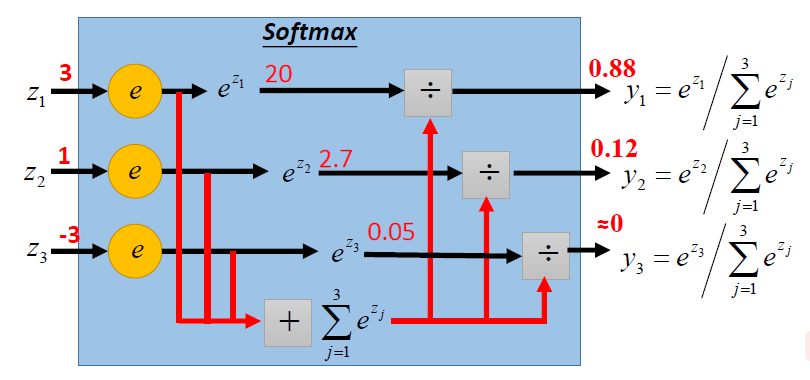
softmax过程，图片来自[这里](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2017/Lecture/Logistic%20Regression%20%28v4%29.pdf)

In [534]:
y = torch.nn.Softmax(dim=1)(z)
y

tensor([[0.8789, 0.1189, 0.0022]])

注意：交叉熵在信息论中log是以2为底，在pytorch中log是以e为底

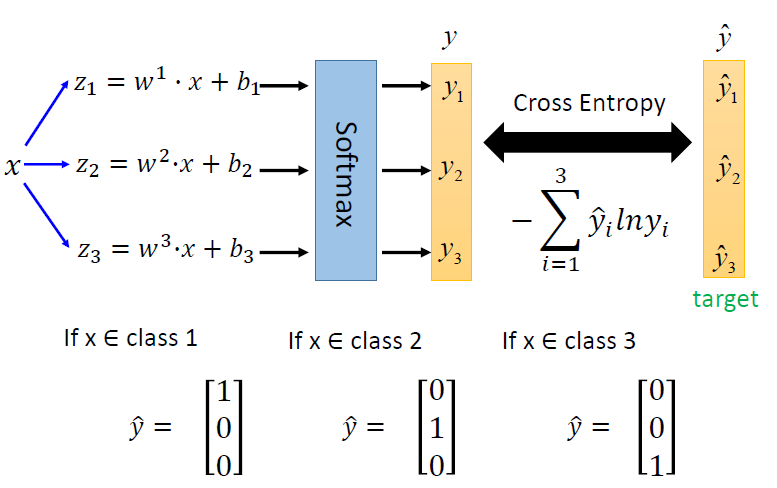
计算CrossEntropy过程，图片来自[这里](http://speech.ee.ntu.edu.tw/~tlkagk/courses/ML_2017/Lecture/Logistic%20Regression%20%28v4%29.pdf)


In [535]:
y_log = torch.log(y)
y_log

tensor([[-0.1291, -2.1291, -6.1291]])

In [536]:
y_hat = torch.tensor([1], dtype=int)
y_hat

tensor([1])

In [537]:
y_1_hot = torch.nn.functional.one_hot(y_hat, class_dim)
y_1_hot

tensor([[0, 1, 0]])

In [538]:
l = torch.tensor(0, dtype=torch.float32)
for y_log_, y_1_hot_ in zip(y_log, y_1_hot):
    l += torch.dot(-y_log_.to(torch.float32), y_1_hot_.to(torch.float32))
l = torch.div(l, len(y_log))
l

tensor(2.1291)

最终对多笔数据求的是**平均**交叉熵

# NLLLoss

The negative log likelihood loss.

In [539]:
def nll_loss(y_log, y_hat):
    y_1_hot = torch.nn.functional.one_hot(y_hat, class_dim)
    l = torch.tensor(0, dtype=torch.float32)
    for y_log_, y_1_hot_ in zip(y_log, y_1_hot):
        l += torch.dot(-y_log_.to(torch.float32), y_1_hot_.to(torch.float32))
    l = torch.div(l, len(y_log))
    return l

In [540]:
F.nll_loss(y_log, y_hat)

tensor(2.1291)

In [541]:
nll_loss(y_log, y_hat)

tensor(2.1291)

可以发现，`nll_loss`输入为经过了softmax和log后值，`nll_loss`所做的操作就是对`y_log`取负号，然后对y_index进行`one hot`编码，最后取真实类标位置上的`-y_log`值，即体现在点乘上

# CrossEntropyLoss

In [542]:
def cross_entropy(z, y_hat):
    y = torch.nn.Softmax(dim=1)(z)
    y_log = torch.log(y)
    return nll_loss(y_log, y_hat)

In [543]:
F.cross_entropy(z, y_hat)

tensor(2.1291)

In [544]:
cross_entropy(z, y_hat)

tensor(2.1291)

可以发现，`cross_entropy`输入是未经过softmax和log后值，`cross_entropy`所做的操作就是对y进行softmax和取log，最后对y_log进行nll_loss

往往数据不会只有1笔，由于计算过程已经对多笔数据支持，所以只需在输入数据上增加

In [554]:
class_dim = 3
data_num = 5
z = torch.randn(data_num, class_dim)
y_hat = torch.ones(data_num, dtype=int).random_(class_dim)
z, y_hat

(tensor([[ 0.2319,  0.2875, -0.2994],
         [ 0.7351, -1.3286, -0.4470],
         [ 0.9836, -0.5633, -0.3552],
         [ 0.8043, -0.3892,  1.2848],
         [ 0.9196,  2.2589, -1.3184]]),
 tensor([2, 0, 2, 1, 1]))

In [555]:
cross_entropy(z, y_hat)

tensor(1.2223)

In [556]:
F.cross_entropy(z, y_hat)

tensor(1.2223)

# CrossEntropy

上面计算过程有个疑问，就是交叉熵为什么要这么求？

首先需要理解交叉熵含义，可以查看这个[知乎回答](https://www.zhihu.com/question/41252833/answer/195901726)加以理解，简单来说，交叉熵损失核心是熵的计算。所以有取log运算和取负号，而$-lnx$函数长这样：
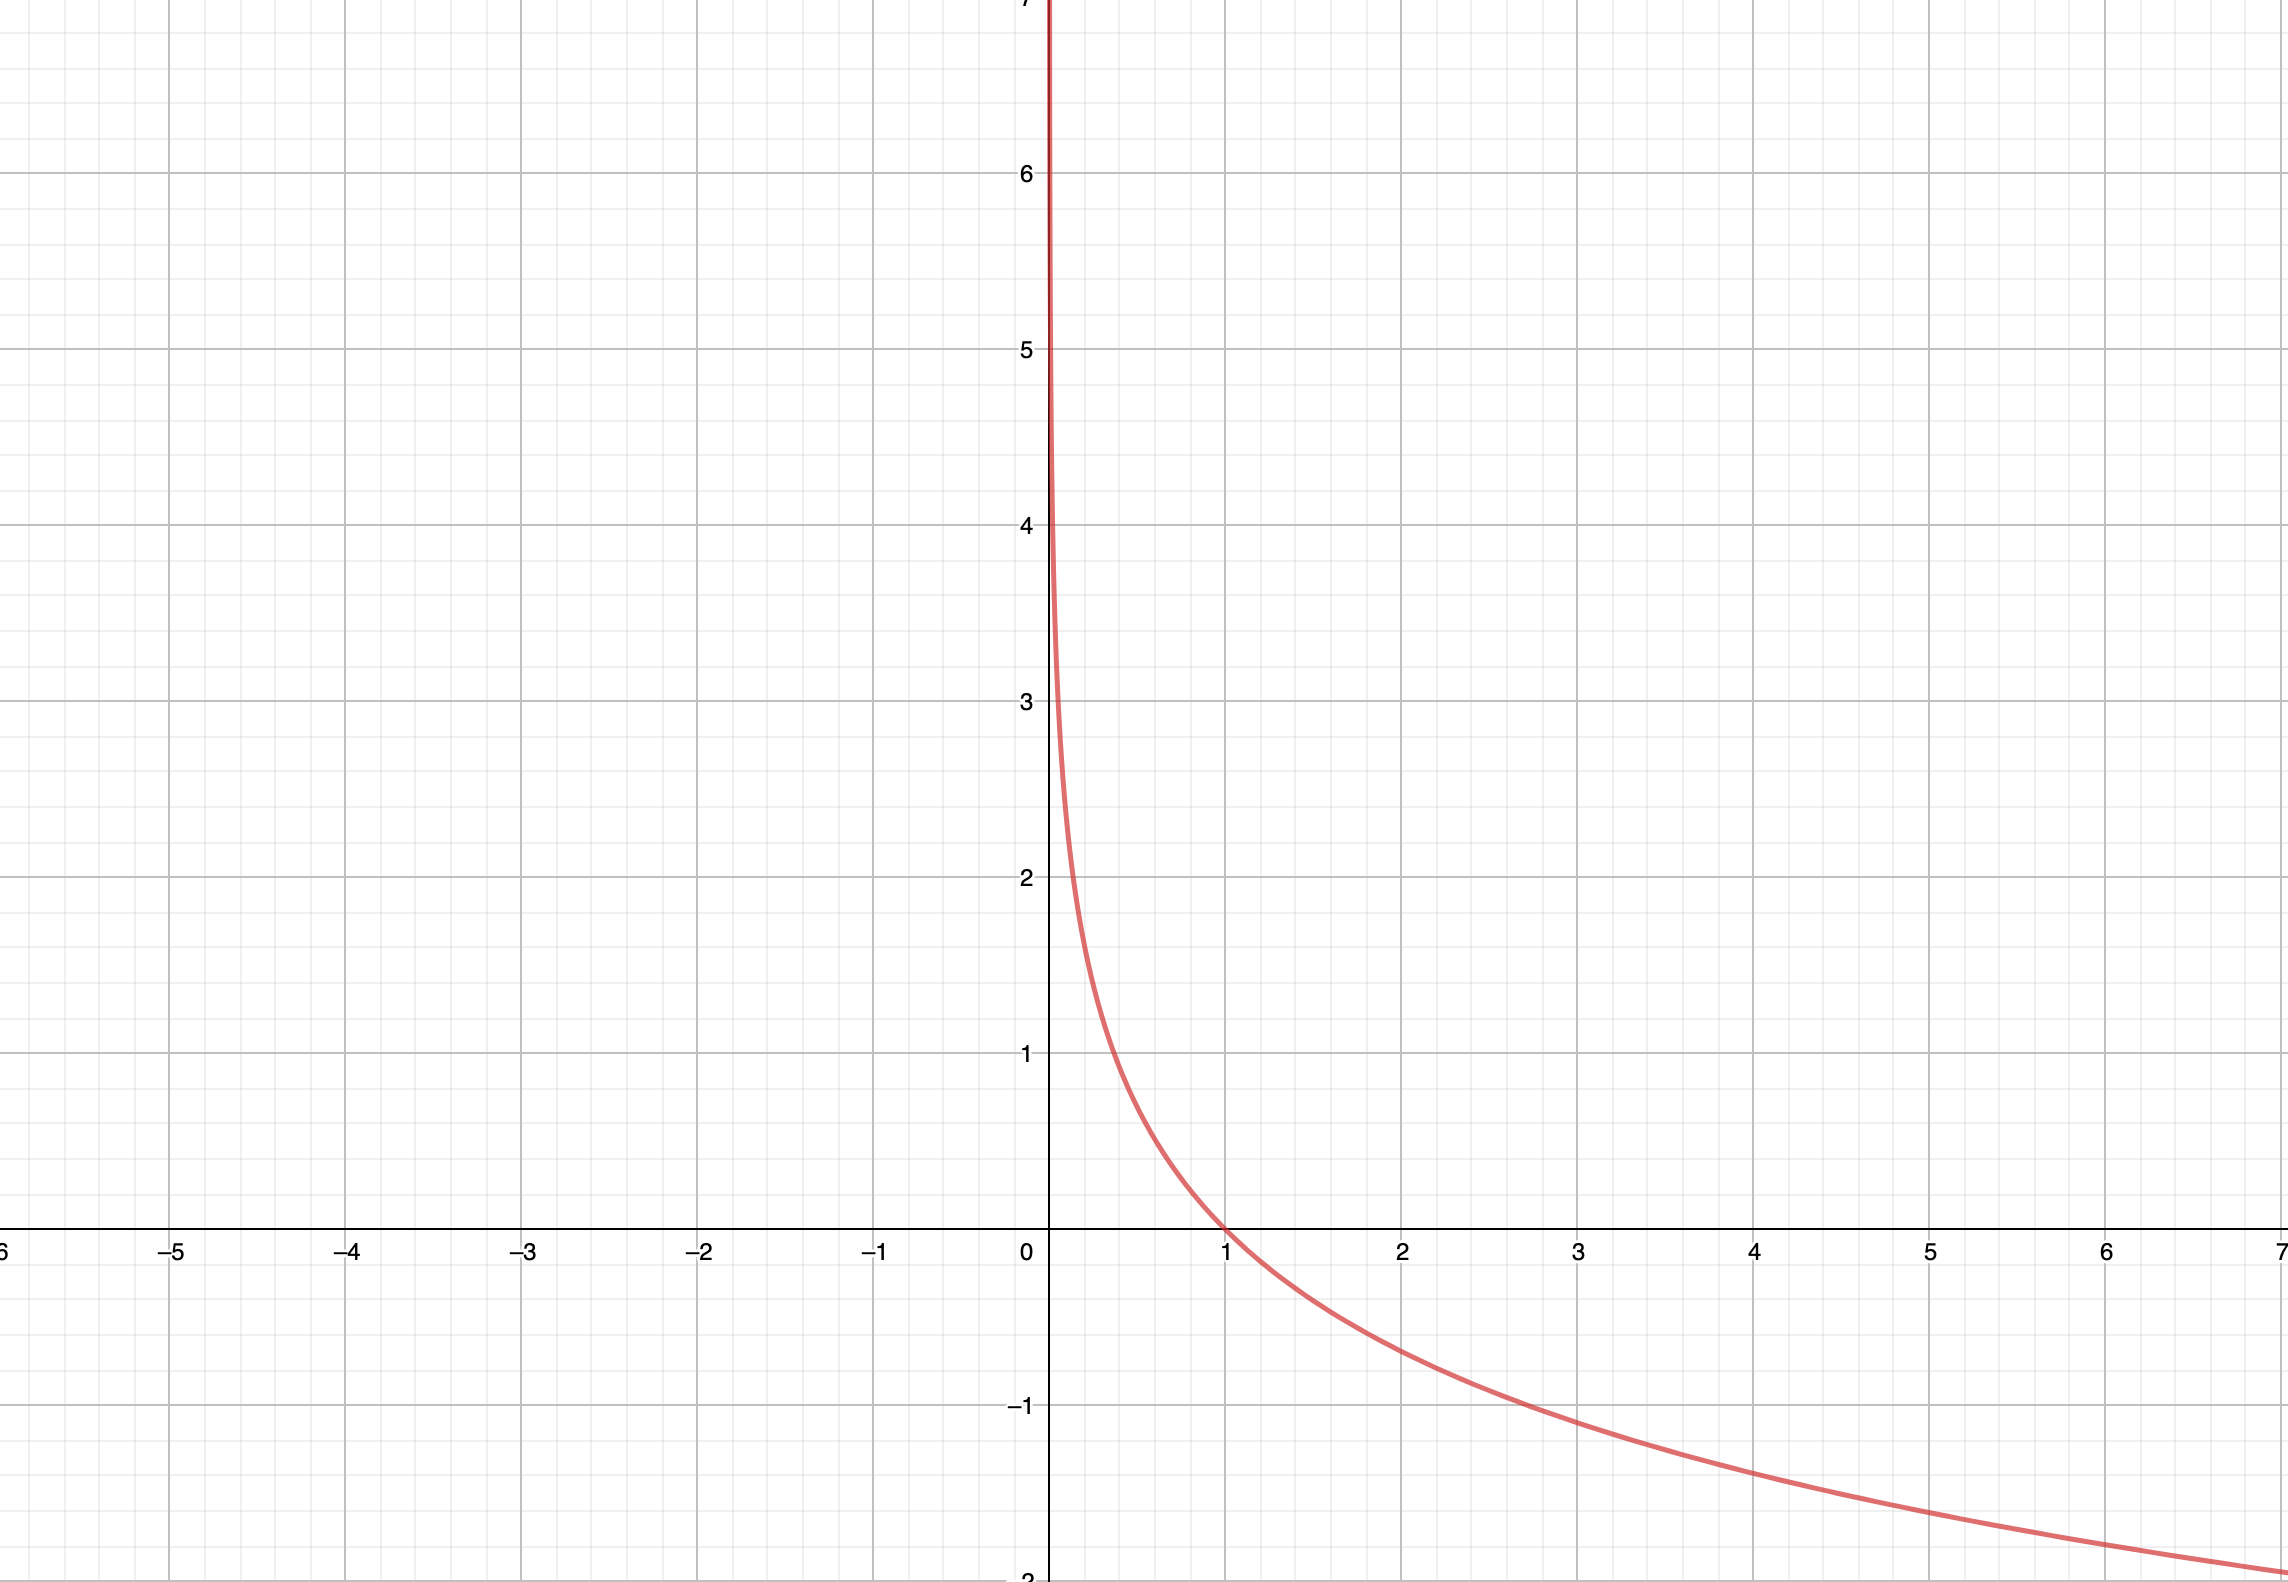
可以发现经过softmax函数后的值域为[0,1]，很好的满足了$-lnx$取值范围。上图也很好体现了信息量关系：概率越小，信息量越大。而信息熵是同分布下信息量在其概率下的期望。

交叉熵求的是非真实分布的信息量在真实分布概率下期望:
$$\sum_{k=1}^{N} p_{k} \log _{2} \frac{1}{q_{k}}$$
或者是机器学习中常用表示(e为低，取负号)
$$\sum_{k=1}^{N} -p_{k} \ln {q_{k}}$$ 
其中$p_{k}$ 表示真实分布, $\quad q_{k}$ 表示非真实分布(预测分布)。
交叉熵在非真实分布与真实分布一样时取得最小。怎么样更好解释这个结论暂时没找到。

那么为什么要求交叉熵最小呢？
实践上我们求的相对熵(KL散度)要最小，即真实分布和非真实分布差异，只是其中的真实分布的信息熵我们已经知道，求相对熵最小即求交叉熵最小。